In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats, integrate

# Discrete auction

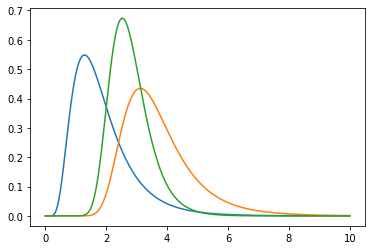

In [29]:
class Distribution:
    
    def __init__(self, dist, N):
        self.N = N
        self.dist = dist
        
    def pdf(self, x):
        return self.dist.pdf(x)
    
    def cdf(self, x):
        return self.dist.cdf(x)

    def fos_pdf(self, x):
        N, cdf, pdf = self.N, self.dist.cdf, self.dist.pdf
        return N*cdf(x)**(N-1)*pdf(x)
        
    def fos_cdf(self, x):
        N, cdf, pdf = self.N, self.dist.cdf, self.dist.pdf
        return cdf(x)**N
    
    def sos_pdf(self, x):
        N, cdf, pdf = self.N, self.dist.cdf, self.dist.pdf
        return N*(N-1)*(1-cdf(x))*cdf(x)**(N-2)*pdf(x)
    
    def sos_cdf(self, x):
        N, cdf, pdf = self.N, self.dist.cdf, self.dist.pdf
        return N*cdf(x)**(N-1) - (N-1)*cdf(x)**N
    
    def exp(self):
        return integrate.quad(lambda x: x*self.pdf(x), -np.inf, np.inf)[0]
    
    def exp_fos(self):
        return integrate.quad(lambda x: x*self.fos_pdf(x), -np.inf, np.inf)[0]
    
    def exp_sos(self):
        return integrate.quad(lambda x: x*self.sos_pdf(x), -np.inf, np.inf)[0]
    
n_bidders = 10
actions = np.arange(11)
dst = stats.lognorm(s=0.5, loc=0, scale=np.exp(0.5))
# dst = stats.uniform()
dist = Distribution(dst, n_bidders)
supp = np.linspace(0,10,500)

exp = dist.exp()
exp_fos = dist.exp_fos()
exp_sos = dist.exp_sos()

plt.plot(supp, dist.pdf(supp))
plt.plot(supp, dist.fos_pdf(supp))
plt.plot(supp, dist.sos_pdf(supp))
# plt.axvline(exp)
# plt.axvline(exp_fos)
# plt.axvline(exp_sos)

In [86]:
from collections import defaultdict
from itertools import product, combinations

n_bidders = 20
actions = np.arange(11)
dst = stats.lognorm(s=0.5, loc=0, scale=np.exp(1))
# dst = stats.uniform()
dist = Distribution(dst, n_bidders)

budget_init = 20
states = np.arange(budget_init)

In [87]:
P = np.zeros((states.size, actions.size, states.size))
R = np.zeros((states.size, actions.size, states.size))

for b, s in enumerate(P):
    for a in actions:
        if b >= a:
            P[b, a, b-a] = dist.fos_cdf(a)
            P[b, a, b] = 1-dist.fos_cdf(a)
            
            R[b, a, :b] = 1

In [88]:
V = np.zeros(states.size)
gamma = 0.99
theta = 1e-5

while True:
    diff = 0
    v = np.copy(V)
    for s in range(states.size):
        V[s] = (P[s] * (R[s]+gamma * v )).sum(axis=1).max()
    diff = np.max([diff, np.max(np.abs(V-v))])
    if diff<= theta:
        break

policy = np.zeros((states.size, actions.size))

for s in range(states.size):
    a = (P[s] * (R[s] + gamma * V)).sum(axis=1).argmax()
    policy[s, a] = 1
    
policy

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.